In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.cm import get_cmap

In [2]:
cm_magma = get_cmap('magma')
cm_plasma = get_cmap('plasma')

In [3]:
# a, b in [0, 1]

def and_gate(vals):
    product = 1
    for value in vals:
        product *= value
    return product

def or_gate(vals):
    return 1 - nor(vals)

def nand(vals):
    return 1 - and_gate(vals)

def nor(vals):
    product = 1
    for value in vals:
        product *= (1-value)
    return product
    
gates = [and_gate, or_gate, nand, nor]

In [4]:
class Node:
    def __init__(self, index=None, discrete=True):
        self.index = index
        if not discrete:
            self.state = np.random.random()
        else:
            self.state = np.random.randint(2)
        self.gate = np.random.choice(gates)
        self.ingoing_indices = []
        self.outgoing_indices = []
        
        
class Network:
    def __init__(self, size, num_inputs=2, discrete=True):
        self.size = size
        self.nodes = np.array([Node(index=i, discrete=discrete) for i in range(size)])
        self.state_history = [self.yield_states()]
        self.time = 0
        self.period = None
        
        self.randomly_connect_nodes(num_inputs=num_inputs)
        
    def randomly_connect_nodes(self, num_inputs=2):
        for node in self.nodes:
            node.ingoing_indices = [np.random.randint(0, self.size) for _ in range(num_inputs)]
            for index in node.ingoing_indices:
                self.nodes[index].outgoing_indices.append(node.index)
                
    def timestep(self):
        updated_states = []
        for i in range(self.size):
            node = self.nodes[i]
            inputs = [self.nodes[node.ingoing_indices[i]].state for i in range(len(node.ingoing_indices))]
            updated_states.append(node.gate(inputs))
            
        self.state_history.append(np.array(updated_states))
        
        self.time += 1
            
        for i in range(self.size):
            self.nodes[i].state = updated_states[i]
            
    def run(self, timesteps):
        for _ in range(timesteps):
            self.timestep()
            
    def show_connections(self):
        for node in self.nodes:
            print(node.ingoing_indices, node.outgoing_indices)
    
    def show_states(self):
        for node in self.nodes:
            print(node.state)
            
    def yield_states(self):
        states = []
        for node in self.nodes:
            states.append(node.state)
        return np.asarray(states)
    
    def show_history(self):
        history_map = np.asarray(self.state_history).transpose()
        history_map = np.flip(history_map, 0)
        fig = plt.imshow(history_map, extent=[0, self.time, 0, self.size], cmap=cm_magma)

        plt.yticks([0, self.size])
        plt.ylabel("State of each node")

        plt.xticks([0, self.time])
        plt.xlabel("Time")
        
        return fig
    
    def detect_period(self, cutoff=0.05, dynamic_extension=True):
        end_state = self.state_history[self.time]
        
        n = 1
        while n > 0:
            state = self.state_history[self.time - n]
            
            if (np.absolute(end_state - state) <= cutoff).all():                
                if n == self.time and dynamic_extension:
                    self.run(self.time)
                    n = self.detect_period()
                
                self.period = n
                return n
            n += 1
        
            
    def decompose_period(self, cutoff=0.005):
        history = np.asarray(self.state_history)
        
        if self.period:
            n = self.period
        else:
            n = self.detect_period(cutoff=cutoff)
        
        divisors = []  # better to cache
        for i in range(1, 1 + int(np.floor(n/2))):  # only test up to n/2
            if n % i == 0:
                divisors.append(i)
        divisors.append(n)
                
        cycles = []
        for i in range(self.size):
            for d in divisors:
                kernel_size = n
                    
                s = 0
                while kernel_size + d >= self.time:  # loops indefinitely sometimes
                    if kernel_size == 1:
                        break
                    kernel_size = divisors[-1-s]
                    s += 1
                    
                kernel = history[-1 - kernel_size: -1, i]
                shifted_kernel = history[-1 - kernel_size - d: -1 - d, i]
                if (np.absolute(kernel - shifted_kernel) <= cutoff).all():
                    if d not in cycles:
                        cycles.append(d)
                    break
        return cycles

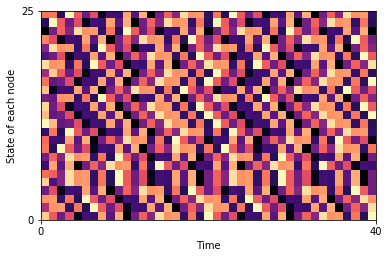

In [5]:
a = Network(25, num_inputs=1, discrete=False)
a.run(40)
a.show_history()

In [6]:
a.decompose_period()

[20]

Text(0.05, 0.5, 'Node')

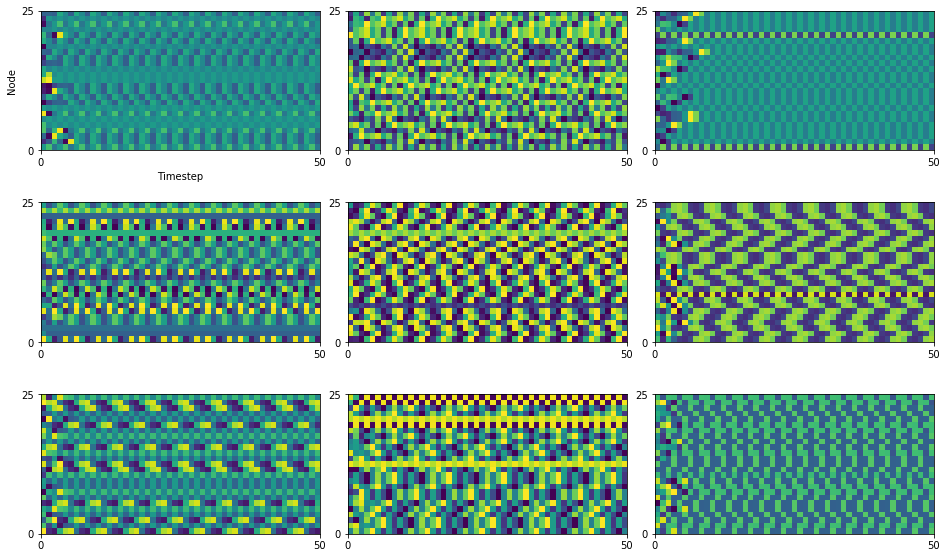

In [7]:
fig, axes = plt.subplots(3,3, figsize=(16, 10), gridspec_kw={"wspace":0.1})

group = [Network(25, num_inputs=1, discrete=False) for _ in range(9)]
for net in group:
    net.run(50)
    
for i in range(3):
    for j in range(3):
        net = group[i + 3*j]
        history_map = np.asarray(net.state_history).transpose()
        history_map = np.flip(history_map, 0)
        axes[i][j].imshow(history_map, extent=[0, net.time, 0, net.size])
        axes[i][j].set_xticks([0, net.time])
        axes[i][j].set_yticks([0, net.size])
        
axes[0][0].set_xlabel("Timestep")
axes[0][0].set_ylabel("Node", position=(0.05,0.5))

(array([90., 42., 25.,  1., 10.,  7.,  3.,  2.,  2.,  1.]),
 array([ 1. ,  2.7,  4.4,  6.1,  7.8,  9.5, 11.2, 12.9, 14.6, 16.3, 18. ]),
 <a list of 10 Patch objects>)

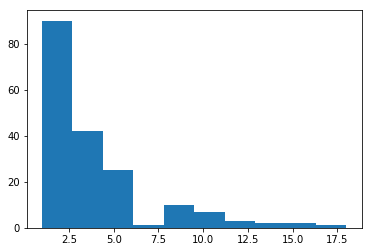

In [8]:
group = [Network(20, num_inputs=1, discrete=False) for _ in range(100)]
cycles = []
for net in group:
    net.run(100)
    net_cycles = net.decompose_period()
    for i in net_cycles:
        cycles.append(i)
    
plt.hist(cycles)